In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import seaborn as sns
import gc

In [2]:
# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7680)]  # 7.5GB
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# 메모리 정리 콜백
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

1 Physical GPUs, 1 Logical GPUs
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
def load_data(data_dir, img_size=(299, 299)):
    images = []
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, img_size)
                images.append(new_array)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(images), np.array(labels)

def load_datasets(train_dir, test_dir, val_dir):
    X_train, y_train = load_data(train_dir)
    X_test, y_test = load_data(test_dir)
    X_val, y_val = load_data(val_dir)

    print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")
    print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")

    return X_train, y_train, X_test, y_test, X_val, y_val

train_dir = 'datasets/Pneumonia/train'
test_dir = 'datasets/Pneumonia/test'
val_dir = 'datasets/Pneumonia/val'

X_train, y_train, X_test, y_test, X_val, y_val = load_datasets(train_dir, test_dir, val_dir)

Train data shape: (5216, 299, 299), Train labels shape: (5216,)
Test data shape: (624, 299, 299), Test labels shape: (624,)
Validation data shape: (16, 299, 299), Validation labels shape: (16,)


In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def load_all_data(base_dir, img_size=(299, 299)):
    images = []
    labels = []
    categories = ['NORMAL', 'PNEUMONIA']
    
    for category in categories:
        class_num = categories.index(category)
        for subset in ['train', 'test', 'val']:
            subset_dir = os.path.join(base_dir, subset, category)
            for img in os.listdir(subset_dir):
                try:
                    img_path = os.path.join(subset_dir, img)
                    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    new_array = cv2.resize(img_array, img_size)
                    images.append(new_array)
                    labels.append(class_num)
                except Exception as e:
                    print(f"Error loading image {img}: {e}")
    
    return np.array(images), np.array(labels)

def split_data(X, y, test_size=0.2, val_size=0.2):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# 데이터 로드 및 분할
base_dir = 'datasets/Pneumonia'
X, y = load_all_data(base_dir)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

# 클래스 분포 확인
def check_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} ({count/len(y)*100:.2f}%)")

print("\nTrain set class distribution:")
check_class_distribution(y_train)
print("\nValidation set class distribution:")
check_class_distribution(y_val)
print("\nTest set class distribution:")
check_class_distribution(y_test)

Train data shape: (3513, 299, 299), Train labels shape: (3513,)
Validation data shape: (1171, 299, 299), Validation labels shape: (1171,)
Test data shape: (1172, 299, 299), Test labels shape: (1172,)

Train set class distribution:
Class 0: 950 (27.04%)
Class 1: 2563 (72.96%)

Validation set class distribution:
Class 0: 316 (26.99%)
Class 1: 855 (73.01%)

Test set class distribution:
Class 0: 317 (27.05%)
Class 1: 855 (72.95%)


In [4]:
def preprocess_image(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.repeat(image, 3, axis=-1)  # 그레이스케일을 3채널로 복제
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .batch(32)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = (
    val_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (
    test_ds
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [18]:
# InceptionV3 모델 로드 및 설정
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# 상위 레이어만 훈련 가능하도록 설정
for layer in base_model.layers[:-50]:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
# 콜백 설정
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# 테스트 데이터로 평가
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/50
110/110 [==============================] - 24s 173ms/step - loss: 0.2393 - accuracy: 0.9012 - val_loss: 0.1495 - val_accuracy: 0.9385
Epoch 2/50
110/110 [==============================] - 19s 159ms/step - loss: 0.1365 - accuracy: 0.9505 - val_loss: 0.1342 - val_accuracy: 0.9428
Epoch 3/50
110/110 [==============================] - 18s 154ms/step - loss: 0.1187 - accuracy: 0.9516 - val_loss: 0.1471 - val_accuracy: 0.9385
Epoch 4/50
110/110 [==============================] - 18s 152ms/step - loss: 0.1035 - accuracy: 0.9599 - val_loss: 0.1800 - val_accuracy: 0.9385
Epoch 5/50
110/110 [==============================] - 19s 165ms/step - loss: 0.0955 - accuracy: 0.9627 - val_loss: 0.1115 - val_accuracy: 0.9573
Epoch 6/50
110/110 [==============================] - 16s 132ms/step - loss: 0.0852 - accuracy: 0.9664 - val_loss: 0.1160 - val_accuracy: 0.9573
Epoch 7/50
110/110 [==============================] - 16s 132ms/step - loss: 0.0847 - accuracy: 0.9681 - val_loss: 0.1169 - val_ac

37/37 [==============================] - 4s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       317
           1       0.98      0.97      0.97       855

    accuracy                           0.96      1172
   macro avg       0.95      0.96      0.95      1172
weighted avg       0.96      0.96      0.96      1172



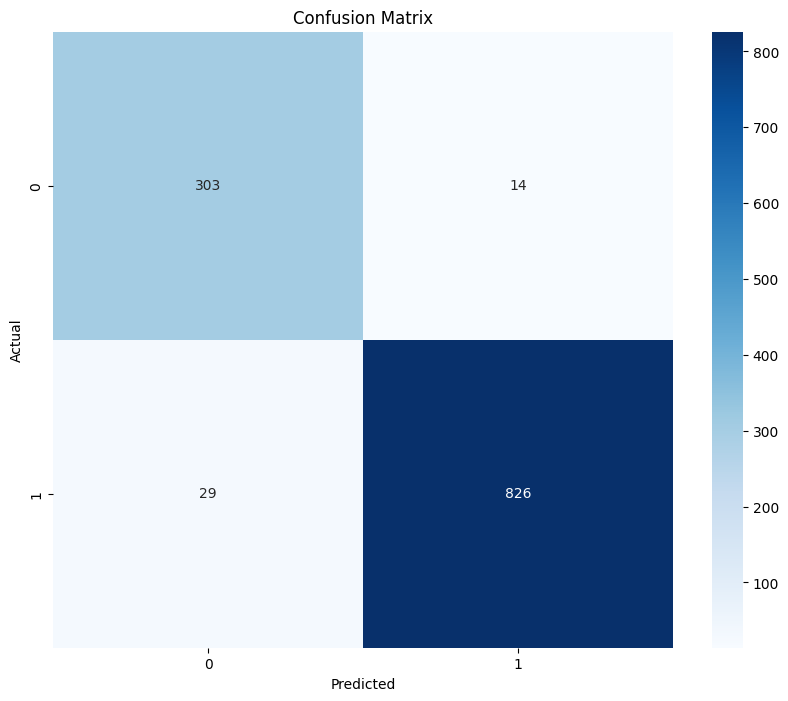

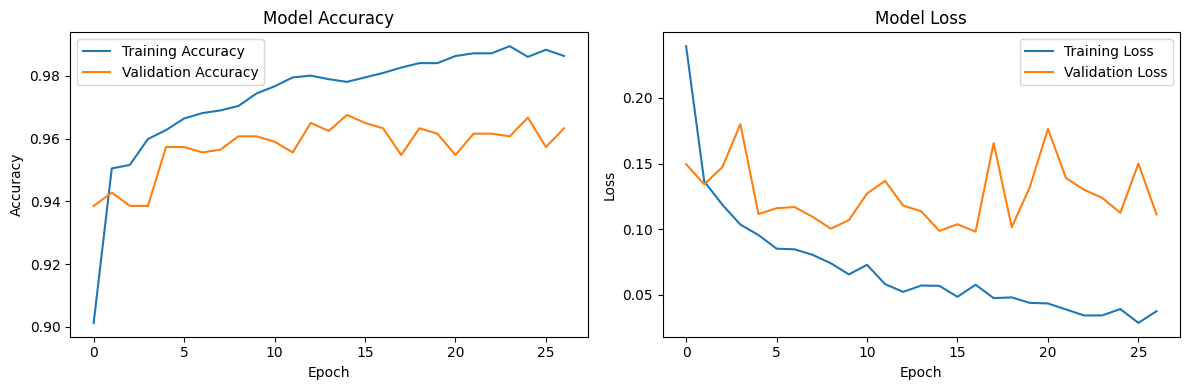


Results Summary:
Test Accuracy: 0.9633
Test Loss: 0.1113

Confusion Matrix Details:
True Negatives: 303
False Positives: 14
False Negatives: 29
True Positives: 826


12362

In [20]:
# 예측
y_pred = model.predict(test_ds)
y_pred_classes = (y_pred > 0.5).astype(int)

# 실제 레이블 추출
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 분류 보고서 출력
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix 계산 및 시각화
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 결과 요약 출력
print("\nResults Summary:")
print(f"Test Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Test Loss: {history.history['val_loss'][-1]:.4f}")

# Confusion Matrix 요소 출력
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix Details:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# 메모리 해제
del history
gc.collect()